In [1]:
# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import regex as re
import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from collections import Counter

In [2]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
        
# remove labels that have less than m occurrences
m = 0

labels_list = df['confirmed'].tolist()
labels_list = sum(labels_list, [])
c = Counter(labels_list)
for i in range(len(df)):
    to_remove = []
    
    # find labels that should be removed 
    for j in range(len(df['confirmed'][i])):
        if c[df['confirmed'][i][j]] < m:
            to_remove.append(j)
            
    # remove the labels
    shift = 0
    for j in range(len(to_remove)):
        df['confirmed'][i].pop(to_remove[j]-shift)
        shift += 1
    
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
df = df[df['confirmed'].map(len) > 0]
df = df.reset_index(drop=True)

In [3]:
df.drop('confirmed', inplace=True, axis=1)
df.drop('suggested', inplace=True, axis=1)
#df = df[0:500]
df.head()

,text,labels
0,Slut på medicin.,"[Känd astma, Känd lungsjukdom]"
1,Behöver att prata med psykolog angående använd...,"[Nedstämdhet, Trötthet]"
2,Har fått besvärlig eksem på händerna,"[Hudbesvär, Synliga hudbesvär]"
3,Muskelsvaghet och trötthet känner mig skakig o...,"[Muskelsvaghet, Trötthet]"
4,Svår smärta i vänsterhanden/handleden precis n...,"[Smärta i handled eller fingrar, Förvärras av ..."


In [4]:
# a basic tokenizer to start off with
def basic_tokenization(text):
    text = text.lower()

    tokens = re.sub(r'[^\p{L} ]', '', text).split()
    
    return tokens

test = 'Hej, hur är läget?'
print(basic_tokenization(test))

['hej', 'hur', 'är', 'läget']


In [5]:
# create dictionary that assigns a unique integer id for each word in the embeddings
word2id = {}
id_count = 0

embedding_weights = None

with open('./embeddings/swectors-300dim.txt', encoding='utf-8') as file:
    # initialize the embedding weights matrix with zeros
    dims = [int(x) for x in file.readline().split()]
    print(dims)
    embedding_weights = torch.zeros((dims[0],dims[1]), dtype=torch.float64)    
    
    line = file.readline().split()
    while line != []:
        word2id[line[0]] = id_count
        embedding_weights[id_count,:] = torch.tensor([float(x) for x in line[1:]])
        id_count += 1
        
        line = file.readline()
        line = line.split()
        
        if id_count % 100000 == 0:
            print(id_count)

[192250, 300]
100000


In [6]:
# train a multilabel_binarizer on the labels
labels = df['labels'].tolist()
multilab_bin = MultiLabelBinarizer()
multilab_bin.fit(labels)

# token-ids used for padding and unknown
pad_tok = word2id['<>']
unk_tok = word2id['<>det']

class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, word2id, multilab_bin, max_len):
        self.tokenizer = tokenizer
        self.word2id = word2id
        self.multilab_bin = multilab_bin
        self.data = dataframe
        self.text = self.data['text']
        self.labels = self.data['labels']
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        
        tokens = self.tokenizer(text)
        # if tokens is empty, add set tokens to ['x']
        if len(tokens) <= 1:
            tokens = ['x']
        
        text_len = len(tokens)
        ids = [0 for i in range(len(tokens))]
        for i in range(len(tokens)):
            if tokens[i] in word2id:
                ids[i] = word2id[tokens[i]]
            else:
                ids[i] = unk_tok
        
        return {
            'lens': text_len,
            'ids': torch.tensor(ids, dtype=torch.long),
            'labels': torch.tensor(np.sum(self.multilab_bin.transform([self.labels[index]]), axis=0), dtype=torch.float)
        }      
    
# collate function for the dataloader
def collate_fn(batch):
    # sort token-id sequences by length
    for_sorting = [(batch[i]['lens'],batch[i]['ids'],batch[i]['labels']) for i in range(len(batch))]
    for_sorting = sorted(for_sorting, key=lambda tup: tup[0], reverse=True)
    
    # pad token-id sequences to max_len_batch
    max_len_batch = for_sorting[0][0]
    
    lens = [0 for i in range(len(batch))]
    ids = torch.zeros((len(batch), max_len_batch), dtype=torch.long)
    labels = torch.zeros((len(batch), len(batch[0]['labels'])))
    
    for i in range(len(batch)):
        temp = torch.tensor([pad_tok for j in range(max_len_batch)])
        temp[:for_sorting[i][0]] = for_sorting[i][1]
        
        lens[i] = for_sorting[i][0]
        ids[i,:] = temp
        labels[i,:] = for_sorting[i][2]
        
    return lens, ids, labels
        

In [7]:
batch_size = 32

# max number of tokens in text
max_len = 0
for i in range(len(df['text'])):
    text = df['text'][i]
            
    tokens = basic_tokenization(text)
    
    if len(tokens) > max_len:
        max_len = len(tokens)

print(max_len)

train_dataset, test_dataset = train_test_split(df,
                                        random_state=42,
                                        test_size=0.2,
                                        shuffle=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = CustomDataset(train_dataset, basic_tokenization, word2id, multilab_bin, max_len)
test_set = CustomDataset(test_dataset, basic_tokenization, word2id, multilab_bin, max_len)

train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': collate_fn
               }
test_params = {'batch_size': batch_size,
               'shuffle': True,
               'num_workers': 0,
               'collate_fn': collate_fn
              }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

print(f'Train set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

99
Train set: 3027 samples
Test set: 757 samples


In [8]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'

print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

# print the device names
for i in range(torch.cuda.device_count()):
    print(f'Device {i}: {torch.cuda.get_device_name(i)}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1
Device 0: Quadro P520


In [9]:
class RNN(nn.Module):
    def __init__(self, embeddings, hidden_dim, output_dim):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # initialize embeddings and make them untrainable
        self.word_embeddings = nn.Embedding.from_pretrained(embeddings)
        self.word_embeddings.weight.requires_grad = False
        
        self.rnn = nn.LSTM(embeddings.shape[1], hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2*hidden_dim, output_dim)
        self.sigm = nn.Sigmoid()
        
    # sentences contains padded token-id sequences sorted by length
    def forward(self, sentences, sent_lengths):
        embeds = self.word_embeddings(sentences)
        
        # pack_padded_sequnce so that padded items won't be shown to the RNN
        if len(sent_lengths) > 1:
            X = torch.nn.utils.rnn.pack_padded_sequence(embeds, sent_lengths, batch_first=True)
        else:
            X = embeds.view(1,sent_lengths[0],-1)
        
        X = X.float()
        _, hc = self.rnn(X)
        
        # make use of the final hidden state
        X = hc[0]
        
        # undo the packing
        #X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)
        
        # reshape X to fit the linear layer
        X = torch.cat((X[0,:,:],X[1,:,:]), 1)
        
        X = self.fc(X)
        X = self.sigm(X)
        
        return X

In [10]:
# compute the loss of an epoch by averaging all batch losses
def epoch_loss(model, data_loader, criterion):
    loss = 0
    batch_count = 0
    
    model.eval()
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            lens, ids, labels = batch
            lens = torch.tensor(lens, dtype=torch.long)#.to(device)
            ids = ids.to(device)
            labels = labels.to(device)
            
            outputs = model(ids, lens)
            loss += criterion(outputs, labels)
            batch_count += 1
    model.train()
    return loss / batch_count

In [11]:
# define the model
output_dim = len(multilab_bin.classes_)
hidden_dim = 500
embedding_weights = embedding_weights.to(device)

model = RNN(embedding_weights, hidden_dim, output_dim)
model.train()
model.to(device)

# number of epochs trained
epochs_trained = 0

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

In [18]:
model.train()

# training loop
learning_rate = 0.0001

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# if the test loss has not improved in the last k epochs, stop training
k = 5

num_epochs = 20
for epoch in range(num_epochs):
    for idx,batch in enumerate(train_loader):
        lens, ids, labels = batch
        lens = torch.tensor(lens, dtype=torch.long)#.to(device)
        ids = ids.to(device)
        labels = labels.to(device)
        
        #print(multilab_bin.inverse_transform(labels.cpu().numpy()))
        #print(ids)
        #print()
        
        # forward pass
        outputs = model(ids, lens)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # save the losses
    train_losses.append(epoch_loss(model, train_loader, criterion))
    test_losses.append(epoch_loss(model, test_loader, criterion))

    epochs_trained += 1
    
    print(f'End of epoch {epochs_trained}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}')
    
    # if the test loss has not improved in the last k epochs break
    if len(test_losses) > k and all(test_losses[-(k+1)] < tl for tl in test_losses[-k:]):
        break

End of epoch 41, Train Loss: 0.0260584, Test Loss: 0.0311658
End of epoch 42, Train Loss: 0.0251414, Test Loss: 0.0307195
End of epoch 43, Train Loss: 0.0243551, Test Loss: 0.0302862
End of epoch 44, Train Loss: 0.0235819, Test Loss: 0.0299477
End of epoch 45, Train Loss: 0.0229353, Test Loss: 0.0299300
End of epoch 46, Train Loss: 0.0221884, Test Loss: 0.0293210
End of epoch 47, Train Loss: 0.0213139, Test Loss: 0.0292728
End of epoch 48, Train Loss: 0.0206009, Test Loss: 0.0291070
End of epoch 49, Train Loss: 0.0199344, Test Loss: 0.0289979
End of epoch 50, Train Loss: 0.0192577, Test Loss: 0.0288369
End of epoch 51, Train Loss: 0.0186792, Test Loss: 0.0285973
End of epoch 52, Train Loss: 0.0179387, Test Loss: 0.0283387
End of epoch 53, Train Loss: 0.0173013, Test Loss: 0.0284058
End of epoch 54, Train Loss: 0.0167985, Test Loss: 0.0283201
End of epoch 55, Train Loss: 0.0161752, Test Loss: 0.0283351
End of epoch 56, Train Loss: 0.0155200, Test Loss: 0.0283238
End of epoch 57, Train L

In [19]:
# get the predicitons and corresponding labels
def get_pred_true(model, data_loader, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
  
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            lens, ids, labels = batch
            lens = torch.tensor(lens, dtype=torch.long)#.to(device)
            ids = ids.to(device)
            labels = labels.to(device)
            
            outputs = model(ids, lens)
            
            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)
            
    return y_pred[1:,:], y_true[1:,:]

model.eval()  
y_pred_temp, y_true = get_pred_true(model, test_loader, output_dim)

Number of labels in training set: 186/197 (94.42 %)
Number of labels in test set: 140/197 (71.07 %)
Number of labels present in both sets: 129/197 (65.48 %)

Micro-average F1-score: 0.533690316822847
Weighted-average F1-score: 0.44799145345987706
Macro-average F1-score: 0.33741924360174236
Accuracy (exact match): 0.2404227212681638
Hamming Loss: 0.007007356047448853


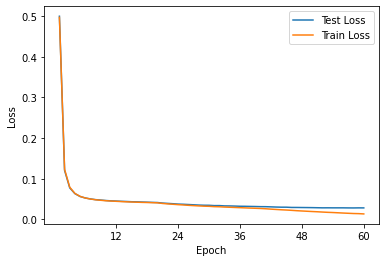

In [20]:
# set all values above threshold to 1, else 0
th = 0.5
y_pred = np.copy(y_pred_temp)
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

# number of labels in test set
#labels_in_test = np.count_nonzero(np.sum(y_true, axis=0))
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)
labels_in_test = np.count_nonzero(label_counts_test)

# number of labels in train set
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
labels_in_train = np.count_nonzero(label_counts_train)

# compute size of intersection between labels in train and test
label_counts_test[label_counts_test > 0] = 1
labels_bin_test = label_counts_test

label_counts_train[label_counts_train > 0] = 1
labels_bin_train = label_counts_train

labels_bin_sum = labels_bin_test + labels_bin_train
labels_intersect = np.count_nonzero(labels_bin_sum[labels_bin_sum == 2])

print(f'Number of labels in training set: {labels_in_train}/{y_true.shape[1]} ({labels_in_train/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels in test set: {labels_in_test}/{y_true.shape[1]} ({labels_in_test/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels present in both sets: {labels_intersect}/{y_true.shape[1]} ({labels_intersect/y_true.shape[1]*100:.2f} %)')
print()
print(f"Micro-average F1-score: {f1_score(y_true, y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_pred, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")

x = [x for x in range(1,len(train_losses)+1)]
xticks = [x*len(train_losses)//5 for x in range(1,6)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(xticks,xticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.gca().set_ylim([0,0.1])
plt.show()

In [21]:
pred_syms = multilab_bin.inverse_transform(y_pred)
true_syms = multilab_bin.inverse_transform(y_true)

for i in range(y_pred.shape[0]):
    print(f'{pred_syms[i]}, {true_syms[i]}')
    print()

(), ('Huvudvärk',)

(), ('Blödande hudbesvär', 'Synliga hudbesvär')

('Huvudvärk',), ('Huvudvärk', 'Kräkningar och illamående', 'Oro eller ångest')

(), ('Sveda vid miktion',)

('Sveda vid miktion',), ('Sveda vid miktion', 'Trängningar')

(), ('Smärta i handled eller fingrar',)

(), ('Röda ögon',)

('Nedstämdhet', 'Oro eller ångest'), ('Nedstämdhet', 'Oro eller ångest')

(), ('Dimsyn', 'Huvudvärk', 'Ögontorrhet')

('Feber', 'Hosta'), ('Hosta', 'Produktiv hosta')

('Halsont', 'Huvudvärk'), ('Feber', 'Halsont', 'Hosta', 'Huvudvärk', 'Snuva', 'Trötthet')

(), ('Bensmärta', 'Hudbesvär', 'Smärta i huden')

(), ('Balans- eller koordinationssvårigheter',)

(), ('Ledsvullnad', 'Smärta i foten')

(), ('Stressig vardag',)

(), ('Röda ögon',)

(), ('Smärta i handled eller fingrar',)

('Hudbesvär', 'Synliga hudbesvär'), ('Synbara maskar vid ändtarmsöppningen',)

(), ('Hudbesvär', 'Klåda')

('Oro eller ångest',), ('Oro eller ångest', 'Stressig vardag')

('Hudbesvär', 'Synliga hudbesvär'), ('Hudbesv

In [16]:
model.eval()
for i in range(len(test_dataset)):
    text = str(test_dataset['text'][i])
    text = ' '.join(text.split())

    tokens = basic_tokenization(text)
    # if tokens is empty, add set tokens to ['x']
    if len(tokens) <= 1:
        tokens = ['x']

    text_len = len(tokens)
    ids = [0 for i in range(len(tokens))]
    for i in range(len(tokens)):
        if tokens[i] in word2id:
            ids[i] = word2id[tokens[i]]
        else:
            ids[i] = unk_tok

    text_len = torch.tensor([text_len], dtype=torch.long).cpu()
    ids = torch.tensor(ids, dtype=torch.long).to(device)
    
    y_pred_row = model(ids, text_len).detach().cpu().numpy()
    
    y_pred_row[y_pred_row > th] = 1
    y_pred_row[y_pred_row <= th] = 0
    
    print(test_dataset['text'][i])
    print(f'Prediction: {multilab_bin.inverse_transform(y_pred_row)}')
    print(f'Labels: {test_dataset["labels"][i]}')
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Vera, 5 år, visar symptom på urinvägsinfektion. Det svider när hon kissar och hon kissar mycket ofta samt har svårt att hålla tätt, vilket hon inte har annars.
Prediction: [()]
Labels: ['Kissar ofta', 'Sveda vid miktion']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Eksem runt ögonen (främst ögonvrån samt under ögat) som inte blir bättre av receptfria läkemedel. Huden är mycket röd, torr och flagnar.
Främst smörjt med locobase repair flera gånger om dagen. Haft detta återkommande varje vinter men bara under ett öga tidigare, är värre i år. Har ej sökt vård för detta tidigare.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - -

Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudförändring på hjässan
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har ont och har haft ont I Halsen I snart 8mån ! Jag har inte haft feber eller någon annan besvär
Prediction: [()]
Labels: ['Halsont']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudförändring på hjässan
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har munsår, munherpes och har haft det i ca 20 år. Har aldrig kollat upp det hos läkare, brukar använda krämer som anti men känns som att det hjälper sämre och sämre. Senaste åren har det varit sår som kommer o

Besvär och kraftig smärta i höger ben. Beror på att en nerv har kommit i kläm enligt sjukgymnasten. Jag tar Alvedon som smärtstillande men detta är inte tillräckligt. Jag skulle behöva mer effektiv smärt medicin.
Prediction: [()]
Labels: ['Bensmärta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har haft besvär i ca 1v med urinvägsinfektion, svider och kommer bara några droppar. Idag vid lunch var urinen blodblandad och varit så sen dess, kommer knappt nånting när jag kissar, ändå är jag super kissenödig. 
Prediction: [()]
Labels: ['Sveda vid miktion']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Kraftig förkylning rinnande näsa
Prediction: [()]
Labels: ['Nästäppa']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag själv mamma, äter sedan 6 dagar herracillin för svinkoppor. Jag har sedan två dagar upptäckt samma typ av utslag i min mellansons ansikte. Samt så har inte mina egna utslag slutat klia.
Prediction: [()]
Labels: ['Hu

Känner obehag/värk i övre delen av magen (mellan revbenen). Kan komma en stund för att sedan gå över och komma tillbaka. Oftast i samband med att jag ätit. Pågått i några dagars tid och än så länge ingen förbättring. 
Prediction: [()]
Labels: ['Buksmärta', 'Uppblåshet']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Har sedan flera veckor haft problem med min andning och varit förkyld. Fick läkartid här innan nyår och fick då Buventol. Dock har det inte blivit bättre, snarare mkt sämre. Har extremt ont i bröstet och även bak i ryggen, hostar och andas tungt samt är väldigt trött. Haft lite feber men inte mkt. Även illamående. Tänker att jag nog behöver medicin. 
Prediction: [()]
Labels: ['Snuva', 'Hosta', 'Kräkningar och illamående', 'Smärta i ryggen, centralt', 'Trötthet', 'Feber', 'Bröstsmärta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Svullnad, rodnad i vänster öga sedan ett par dagar! Ögat rinner och värker och synen påverkas negativt.
Predic

Har fått massa utslag i ansiktet, liknande finnar, vissa gör ej ont utan är bara röda, andra gör väldigt ont och är inflammerade. Haft detta ca 1-2 månader. Placering käkar & öronhöjd inåt ansiktet. Har aldrig haft problem med finnar innan. 
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Klåda i ansikte  hårfäste, kinder och haka. Känt det ca två veckor blivit mera de sista dagarna och rödare.
Prediction: [()]
Labels: ['Klåda', 'Hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har munsår, munherpes och har haft det i ca 20 år. Har aldrig kollat upp det hos läkare, brukar använda krämer som anti men k

Har haft fruktansvärd mensvärk i en veckas tid och har inte mens just nu, det gör så fruktansvärt ont att jag inte vet vart jag ska ta vägen, värken går i skov. Äter minipiller 
Prediction: [()]
Labels: ['Svår mensvärk', 'Får mens']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har haft huvudvärk under ca 1 veckas tid. I lördags började jag få utslag som liknar finnar över vänstra sidan av ansiktet. Har också väldigt ont i tänderna på vänstra sidan. Hade under ett par dagar ont i vänster öra.
Prediction: [()]
Labels: ['Ont i örat', 'Hudbesvär', 'Synliga hudbesvär', 'Huvudvärk']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Haft bältros,  har nu ont i huvudet och mår illa. Orkeslöshet, och ont i magen. 
Prediction: [()]
Labels: ['Blekhet', 'Buksmärta', 'Kräkningar och illamående', 'Huvudvärk', 'Trötthet']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudförändring på hjässan
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesv

Prediction: [()]
Labels: ['Kissar ofta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Besvär och kraftig smärta i höger ben. Beror på att en nerv har kommit i kläm enligt sjukgymnasten. Jag tar Alvedon som smärtstillande men detta är inte tillräckligt. Jag skulle behöva mer effektiv smärt medicin.
Prediction: [()]
Labels: ['Bensmärta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Haft smärta och rodnad i halsen, svullna tonciller, och lymfor sedan måndag 21/12 fick kåvepenin behandling med start 26/12 utan effekt.
 efter 3 behandlings dagar har symtom förvärrats med något ökad svullnad och smärta.  
Prediction: [()]
Labels: ['Svullna tonsiller']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Känner obehag/värk i övre delen av magen (mellan revbenen). Kan komma en stund för att sedan gå över och komma tillbaka. Oftast i samband med att jag ätit. Pågått i några dagars tid och än så länge ingen förbättring. 
Prediction: [()]
Labels: [

Prediction: [()]
Labels: ['Klåda', 'Hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har ont och har haft ont I Halsen I snart 8mån ! Jag har inte haft feber eller någon annan besvär
Prediction: [()]
Labels: ['Halsont']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ont i halsen feber
Prediction: [()]
Labels: ['Halsont']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Covid
Hostan ger inte med sig
Cocillana hjälper inte
Behöver luftrörsvidgande
Prediction: [()]
Labels: ['Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudförändring på hjässan
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Covid
Hostan ger inte med sig
Cocillana hjälper inte
Behöver luftrörsvidgande
Prediction: [()]
Labels: ['Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Vår dotter har troligen covid och en hemsk hosta som vi under 

Gravid i snart v.17. Börjat få rejäla problem med sura uppstötningar. Tagit samarin och novalucol x flera senaste veckan, även nattetid. Recept på Omeprazol?
Prediction: [()]
Labels: ['Gravid', 'Reflux']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Problem med hälsenan i ca 4 månader nu. Ständig smärta som varierar i grad. Känns som någon form av inflammation. Det blir inte bättre och jag behöver hjälp att få rätt på det. 
Vill gärna ha ett fysiskt möte. Hör ej i telefon så mailkontakt fungerar bäst. jenny@jensenonline.se
Prediction: [()]
Labels: ['Smärta i foten']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ganska lätt husta och jag få lite doligt luft 
Prediction: [

Känner obehag/värk i övre delen av magen (mellan revbenen). Kan komma en stund för att sedan gå över och komma tillbaka. Oftast i samband med att jag ätit. Pågått i några dagars tid och än så länge ingen förbättring. 
Prediction: [()]
Labels: ['Buksmärta', 'Uppblåshet']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Mycket huvudvärk - mycket ont i käken från igår .
Jag känner mig yr!!
Min blodtryck är 150/80.
Tack.julian .
Prediction: [()]
Labels: ['Huvudvärk']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har rethosta som mest kommer under natten och det är jättejobbig att sova . Jag behöver någon sorts av hostmedicin 
Prediction: [()]
Labels: ['Snuva', 'Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Har fått massa utslag i ansiktet, liknande finnar, vissa gör ej ont utan är bara röda, andra gör väldigt ont och är inflammerade. Haft detta ca 1-2 månader. Placering käkar & öronhöjd inåt ansiktet. Har aldrig haft problem me

Allvarlig trafikolycka för snart ett år sedan. Mycket tankar och oro. Ledsen. Ängslan att det ska hända igen. Skulle behöva prata med någon om mina känslor.
Prediction: [()]
Labels: ['Oro eller ångest']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Koll av leverfläck som växer både utåt och inåt. Känns som en knuta invändigt och har inte tidigare gjort så. 
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
test marcus hosta

Prediction: [()]
Labels: ['Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Har haft fruktansvärd mensvärk i en veckas tid och har inte mens just nu, det gör så fruktansvärt ont att jag inte vet vart jag ska ta vägen, värken går i skov. Äter minipiller 
Prediction: [()]
Labels: ['Svår mensvärk', 'Får mens']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Den 7/12 fick jag feber och 10/12 fick jag positivt covid-19 prov, jag har hostat, 

Prediction: [()]
Labels: ['Nedstämdhet', 'Oro eller ångest']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hosta
Prediction: [()]
Labels: ['Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Började med igår att mitt vänstra öga började värka lite, men nu så är ögat rött och värker jätte mycket och göt jätte ont.
Prediction: [()]
Labels: ['Svullnad och rodnad i ögonvrån eller runt ögat', 'Röda ögon', 'Tårande ögon', 'Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ischiasproblem som orsakar smärta. Önskar smärtstillande/ muskelavslappnande. Jag går hos sjukgymnast.
Prediction: [()]
Labels: ['Bensmärta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Har under lång tid haft hög belastning. För ett par månader började jag få svårt att fokusera, få saker gjort och fick allt mer ångest. För ett par veckor sedan tog det stopp helt och har inte jobbat sedan dess. Har haft kontakt med VC men min läkartid blev inst

Haft smärta och rodnad i halsen, svullna tonciller, och lymfor sedan måndag 21/12 fick kåvepenin behandling med start 26/12 utan effekt.
 efter 3 behandlings dagar har symtom förvärrats med något ökad svullnad och smärta.  
Prediction: [()]
Labels: ['Svullna tonsiller']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ischiasproblem som orsakar smärta. Önskar smärtstillande/ muskelavslappnande. Jag går hos sjukgymnast.
Prediction: [()]
Labels: ['Bensmärta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Svullnad, rodnad i vänster öga sedan ett par dagar! Ögat rinner och värker och synen påverkas negativt.
Prediction: [()]
Labels: ['Svullnad och rodnad i ögonvrån eller runt ö

Utslag runt näsa och på haka, tror det är perioral dermatit. Vill ha utskrivet någon typ av läkemedel mot det om det stämmer
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Covid
Hostan ger inte med sig
Cocillana hjälper inte
Behöver luftrörsvidgande
Prediction: [()]
Labels: ['Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Den 7/12 fick jag feber och 10/12 fick jag positivt covid-19 prov, jag har hostat, huvudvärk, jätteont i musklerna tappat lukt/smak, jag har sovit o svettats hela tiden fram 16/12. Vaknade o plötsligt mådde jag bra, som en vanlig förkylning hostan är dock kvar o huvudvärken. På fredag pratade jag med jobbet o jag lät så bra att vi bestämde att jag går o jobbar dag 15, måndag 21/12. Nu är jag osäker om jag klarar det, pga av hostan , huvudvärken
Prediction: [()]
Labels: ['Nästäppa', 'Nyligen testat positivt för Covid-19', 'Hosta']
- - - - - - - - - - - - - - - - - - - 

Diskutera medicinering 
Prediction: [()]
Labels: ['Sömnsvårigheter']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Eksem runt ögonen (främst ögonvrån samt under ögat) som inte blir bättre av receptfria läkemedel. Huden är mycket röd, torr och flagnar.
Främst smörjt med locobase repair flera gånger om dagen. Haft detta återkommande varje vinter men bara under ett öga tidigare, är värre i år. Har ej sökt vård för detta tidigare.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har feber. Hostar väldigt mycket. Svag i benet. Snuvig 
Prediction: [()]
Labels: ['Feber', 'Snuva', 'Hosta', 'Muskelsvaghet']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag har varit förkyld och hostade
Kraftig och näsan ran ifyra fem
Dagar och hade tappat lockt och 
Smacksinne men de närmaste 
Dagarna mor jag bättra. 
Prediction: [()]
Labels: ['Snuva']
- - - - - - - - - - - - - - - - - - - - - - - 

Prediction: [()]
Labels: ['Nedstämdhet']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Jag haft hosta i ca 6dagar, jag har tagit apoteket hostmedicin men den funkar inte. Jag tänkte om ni kunde ge mig mollipect mot min hosta
Prediction: [()]
Labels: ['Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ibland jag kan inte andas bra jag känner mig det finns nått i luftvägarna det brinner hela tiden jag ta medicin panteorazol men det hjälper inte
Prediction: [()]
Labels: ['Svårt att få luft', 'Svårt att andas']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ont i nacke, axlar och tiningen/ögat. Haft ont till och från sen 23e.
Prediction: [()]
Labels: ['S

Depression ökning. Självmordstankar, ångest varje dag. 
Prediction: [()]
Labels: ['Nedstämdhet', 'Oro eller ångest']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudförändring på hjässan
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Den 7/12 fick jag feber och 10/12 fick jag positivt covid-19 prov, jag har hostat, huvudvärk, jätteont i musklerna tappat lukt/smak, jag har sovit o svettats hela tiden fram 16/12. Vaknade o plötsligt mådde jag bra, som en vanlig förkylning hostan är dock kvar o huvudvärken. På fredag pratade jag med jobbet o jag lät så bra att vi bestämde att jag går o jobbar dag 15, måndag 21/12. Nu är jag osäker om jag klarar det, pga av hostan , huvudvärken
Prediction: [()]
Labels: ['Nästäppa', 'Nyligen testat positivt för Covid-19', 'Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Har haft fruktansvärd mensvärk i en veckas tid och har inte mens just 

Eksem i ansiktet.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudutslag på höger skinka. Behandlats med mildison i ungefär en månad utan framgång.
Han upplever att det kliar ibland. 

Prediction: [()]
Labels: ['Klåda', 'Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Återkommande spontanblödningar i min vänstra fot, fem gånger på ett år. Inget trauma. Kan inte stödja på den. 
Prediction: [()]
Labels: ['Smärta i foten']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Började med igår att mitt vänstra öga började värka lite, men nu så är ögat rött och värker jätte m

Gravid i snart v.17. Börjat få rejäla problem med sura uppstötningar. Tagit samarin och novalucol x flera senaste veckan, även nattetid. Recept på Omeprazol?
Prediction: [()]
Labels: ['Gravid', 'Reflux']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Sedan 1 månad tillbaka rodnad insidan knäet, som till en början var ca 8x5cm, nu ca 15 x 12. Var mer mörkrött i början och nu ljusare. Ingen klåda. Ingen feber.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Covid
Hostan ger inte med sig
Cocillana hjälper inte
Behöver luftrörsvidgande
Prediction: [()]
Labels: ['Hosta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Allergiutslag kring hals och ansikte
Prediction: [()]
Labels: ['Svullnad och rodnad i ögonvrån eller runt ögat']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ganska lätt husta och jag få lite doligt luft 
Prediction: [()]
Labels: ['Blödningsbenägenhet

Prediction: [()]
Labels: ['Klåda', 'Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hej. Jag har ett envist exem på knogen höger hand. Har haft det i ett halvår. Vid behandling med receptfri kortison blir det snabbt bättre men återkommer sedan lika snabbt (inom några dagar), även när jag behandlat en hel vecka för säkerhets skull. Skulle behöva råd och kanske någon alternativ behandling.
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudförändring på hjässan
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvär']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Ischiasproblem som orsakar smärta. Önskar smärtstillande/ muskelavslappnande. Jag går hos sjukgymnast.
Prediction: [()]
Labels: ['Bensmärta']
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
Hudförändring på hjässan
Prediction: [()]
Labels: ['Hudbesvär', 'Synliga hudbesvä